# GitHub OAuth

## Get [token](https://github.com/settings/tokens)

When you get a url with token, the limit of times become 5000 times per.

two ways to get token:

1. Request directly (easy and quick).
2. Through Application (not recommend)
 


### 1. Directly 
https://github.com/settings/tokens

In [1]:
# token = 

### 2. Through Application (If first does not work)
***Skip the next two cells part below if you have token.*** 

Set [Application](https://github.com/settings/applications) in github, and copy id/secret below.  
Make sure set up your application.

In [2]:
import json, requests
# set client id/secret
client_id = "1a75ffc18204dc5b1b8d"
client_secret = "0090b56dfa952edf488e88d97fd112a944873417"
retrieve_code_url = "https://github.com/login/oauth/authorize?client_id="+client_id#+"&scope=users"
print "Login in this link retrieve cookie:\t", retrieve_code_url
print "\nThen set cookie in the next cell"

Login in this link retrieve cookie:	https://github.com/login/oauth/authorize?client_id=1a75ffc18204dc5b1b8d

Then set cookie in the next cell


In [3]:
# set cookie
cookie = {"user_session":"8Qdo3cJueaRXNpw-NPYva5JuGpRHwefEHmOuHWo9UWgl9WtSVrZ2asrPbtx_KuEg33-EUwQGjEqwM0nX"}
# retrieving code
import re
code_r = requests.request("get", retrieve_code_url, cookies = cookie)
code = code_r.url.split("?code=")[-1]
# print "This code is required by Oauth,",code
# retrieving token
token_r = requests.post(
    'https://github.com/login/oauth/access_token', 
    data=json.dumps({
        'client_id':client_id, 
        'client_secret':client_secret,
        'code':code
    }),
    headers={'content-type':'application/json'}
)
match = re.search(r'(?<=access_token=)[0-9a-f]*',token_r.text)
token = match.group()
token

u'f395c501ca61c8c37fc32c0d6ecf200bd49a7ae5'

#### Check limits

In [4]:
json.loads(requests.get("https://api.github.com/rate_limit?access_token="+token).content)

{u'rate': {u'limit': 5000, u'remaining': 4999, u'reset': 1455121736},
 u'resources': {u'core': {u'limit': 5000,
   u'remaining': 4999,
   u'reset': 1455121736},
  u'search': {u'limit': 30, u'remaining': 30, u'reset': 1455118326}}}

## Simple example

In [5]:
import json, requests

url = "https://api.github.com/users?access_token="+token+"&&per_page=100"
res = json.loads(requests.get(url).content)

Find missing users according to the response

In [6]:
def findMissing(li):
    missing = []
    start = li[0]
    for i in sorted(li):
        if i==start:
            last = i
            continue
        if i-last > 1:
            missing += range(last+1,i)
            last = i
        else:
            last = i
    end = i
    print "From %d to %d, totally missing # is %d,\
     missing rate %.4f" % (start, end, len(missing), len(missing)*1.0/(end-start+1))
    return missing, start, end

In [7]:
missing, _, _ = findMissing([i["id"] for i in res])
print "Missing list is",
print missing

From 1 to 135, totally missing # is 35,     missing rate 0.2593
Missing list is [8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 33, 39, 40, 41, 42, 43, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 86, 96, 97, 98, 99]


## Find Current Max Id

In [8]:
def minmax(id):
    url = "https://api.github.com/users?since="+str(id)+"&access_token="+token+"&&per_page=100"
    l = len(json.loads(requests.get(url).content))
    return l

def findMax(upper, lower=1):
    if upper <= lower or minmax(upper) > 0 or minmax(lower)==0:
        return None
    if upper-lower==1:
        return lower
    else:
        sep = (upper+lower)/2
        return findMax(upper,sep) or findMax(sep, lower)

In [9]:
# before findMax
json.loads(requests.get("https://api.github.com/rate_limit?access_token="+token).content)

{u'rate': {u'limit': 5000, u'remaining': 4998, u'reset': 1455121736},
 u'resources': {u'core': {u'limit': 5000,
   u'remaining': 4998,
   u'reset': 1455121736},
  u'search': {u'limit': 30, u'remaining': 30, u'reset': 1455118342}}}

In [10]:
m = 1
m_res = findMax(m)
while not m_res:
    m <<= 2
    m_res = findMax(m)
print "Max id is:", m_res

Max id is: 17162813


In [11]:
# after findMax
json.loads(requests.get("https://api.github.com/rate_limit?access_token="+token).content)

{u'rate': {u'limit': 5000, u'remaining': 4904, u'reset': 1455121736},
 u'resources': {u'core': {u'limit': 5000,
   u'remaining': 4904,
   u'reset': 1455121736},
  u'search': {u'limit': 30, u'remaining': 30, u'reset': 1455118370}}}

In [14]:
# good guess can reduce accessing times
m_res = findMax(17400000,17000000)
print "Max id is:", m_res

Max id is: 17162825


In [42]:
json.loads(requests.get("https://api.github.com/rate_limit?access_token="+token).content)

{u'rate': {u'limit': 5000, u'remaining': 4235, u'reset': 1454813629},
 u'resources': {u'core': {u'limit': 5000,
   u'remaining': 4235,
   u'reset': 1454813629},
  u'search': {u'limit': 30, u'remaining': 30, u'reset': 1454811769}}}

## Missing distribution

In [45]:
sample_distribution = []
for i in range(0,m_res/10000*10000,10000):
    url = "https://api.github.com/users?since="+str(i)+"&access_token="+token+"&&per_page=100"
    res = json.loads(requests.get(url).content)
    l,s,e = findMissing([i["id"] for i in res])
    sample_distribution.append(len(l)*1.0/(e-s))

From 1 to 135, totally missing # is 35,     missing rate 0.2593
From 10001 to 10107, totally missing # is 7,     missing rate 0.0654
From 20001 to 20104, totally missing # is 4,     missing rate 0.0385
From 30001 to 30108, totally missing # is 8,     missing rate 0.0741
From 40001 to 40105, totally missing # is 5,     missing rate 0.0476
From 50001 to 50103, totally missing # is 3,     missing rate 0.0291
From 60001 to 60107, totally missing # is 7,     missing rate 0.0654
From 70001 to 70106, totally missing # is 6,     missing rate 0.0566
From 80001 to 80117, totally missing # is 17,     missing rate 0.1453
From 90001 to 90107, totally missing # is 7,     missing rate 0.0654
From 100001 to 100108, totally missing # is 8,     missing rate 0.0741
From 110001 to 110105, totally missing # is 5,     missing rate 0.0476
From 120001 to 120103, totally missing # is 3,     missing rate 0.0291
From 130001 to 130104, totally missing # is 4,     missing rate 0.0385
From 140001 to 140105, totally

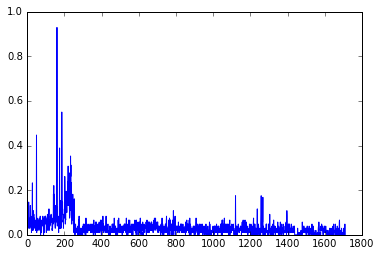

In [47]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(sample_distribution)

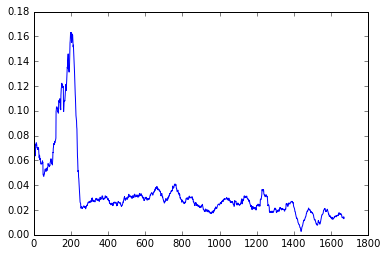

In [50]:
avg_span = 40
plt.plot([sum(sample_distribution[i:i+avg_span])/avg_span for i in xrange(len(sample_distribution)-avg_span)])

In [52]:
import numpy as np
dist = np.array(sample_distribution)
dist.mean()

0.034409688035665367

In [6]:
print "total acounts:\t\t",m_res
print "missing acounts:\t",int(round(dist.mean()*m_res))
print "active acounts:\t\t",int(round((1-dist.mean())*m_res))

total acounts:		

NameError: name 'm_res' is not defined

In [10]:
res

[{u'avatar_url': u'https://avatars.githubusercontent.com/u/1?v=3',
  u'events_url': u'https://api.github.com/users/mojombo/events{/privacy}',
  u'followers_url': u'https://api.github.com/users/mojombo/followers',
  u'following_url': u'https://api.github.com/users/mojombo/following{/other_user}',
  u'gists_url': u'https://api.github.com/users/mojombo/gists{/gist_id}',
  u'gravatar_id': u'',
  u'html_url': u'https://github.com/mojombo',
  u'id': 1,
  u'login': u'mojombo',
  u'organizations_url': u'https://api.github.com/users/mojombo/orgs',
  u'received_events_url': u'https://api.github.com/users/mojombo/received_events',
  u'repos_url': u'https://api.github.com/users/mojombo/repos',
  u'site_admin': False,
  u'starred_url': u'https://api.github.com/users/mojombo/starred{/owner}{/repo}',
  u'subscriptions_url': u'https://api.github.com/users/mojombo/subscriptions',
  u'type': u'User',
  u'url': u'https://api.github.com/users/mojombo'},
 {u'avatar_url': u'https://avatars.githubusercontent